In [ ]:
#########################################
# Hotel CieloAzul - Gestión Hotelera
#########################################


#librerias

import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
import os
import getpass
import platform



#Registro de eventos, se coloca antes para que se pueda registrar todo lo que se va correr durante el codigo

#librerias
from time import time
from datetime import datetime

# Ruta del archivo log
log_file = "log_eventos.txt"

# Inicializa el archivo con información del sistema
def inicializar_log():
    if not os.path.exists(log_file):
        with open(log_file, "w", encoding="utf-8") as f:
            f.write("=== Registro de Eventos del Hotel CieloAzul ===\n")
            f.write(f"Usuario del sistema: {getpass.getuser()}\n")
            f.write(f"Sistema operativo: {platform.system()}\n")
            f.write(f"Plataforma: {platform.platform()}\n")
            f.write("--------------------------------------------------\n\n")

# Registra cada evento con timestamp y duración
def registrar_evento(accion):
    inicio = time()
    # Puedes medir duración real si lo necesitas
    fin = time()
    duracion = round(fin - inicio, 4)
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]

    with open(log_file, "a", encoding="utf-8") as f:
        f.write(f"{timestamp} | {accion} | Duración: {duracion}s\n")



#Ejecutar registro

inicializar_log()



#Registro de huesped

# aqui se crea la base de datos en la memoria
huespedes = pd.DataFrame(columns=["Nombre", "Apellido", "Documento", "Correo", "Teléfono"])

# Validaciones
def validar_nombre(nombre):
    return nombre.isalpha() and len(nombre) >= 3

def validar_apellido(apellido):
    return apellido.isalpha() and len(apellido) >= 3

def validar_documento(documento):
    return documento.isdigit() and 3 <= len(documento) <= 15

def validar_correo(correo):
    patron = r"^[\w\.-]+@[\w\.-]+\.\w+$"
    return re.match(patron, correo) is not None

def validar_telefono(telefono):
    return telefono.isdigit() and 7 <= len(telefono) <= 15

# Función de registro
def registrar_huesped():
    print("\n Registro de Huésped")
    nombre = input("Nombre: ").strip()
    apellido = input("Apellido: ").strip()
    documento = input("Documento de identidad: ").strip()
    correo = input("Correo electrónico: ").strip()
    telefono = input("Teléfono de contacto: ").strip()

    errores = []
    if not validar_nombre(nombre):
        errores.append("Nombre inválido (mín. 3 letras, solo letras).")
    if not validar_apellido(apellido):
        errores.append("Apellido inválido (mín. 3 letras, solo letras).")
    if not validar_documento(documento):
        errores.append("Documento inválido (entre 3 y 15 dígitos numéricos).")
    if not validar_correo(correo):
        errores.append("Correo electrónico inválido.")
    if not validar_telefono(telefono):
        errores.append("Teléfono inválido (entre 7 y 15 dígitos numéricos).")
    if documento in huespedes["Documento"].values:
        errores.append("Este documento ya está registrado.")

    if errores:
        print("\n Errores encontrados:")
        for err in errores:
            print(f" - {err}")
    else:
        huespedes.loc[len(huespedes)] = [nombre, apellido, documento, correo, telefono]
        print("\n Huésped registrado exitosamente.")
        registrar_evento("Registrar huésped")


#Reserva de habitacion
from datetime import datetime, timedelta

# DataFrame para reservas
reservas = pd.DataFrame(columns=["Documento", "Tipo", "N° Habitación", "Ingreso", "Salida", "Noches", "Costo", "CheckIn"])



# Habitaciones disponibles
habitaciones = {
    "estandar": list(range(1, 31)),  # habitaciones 1 a 30
    "suite": list(range(31, 41))     # habitaciones 31 a 40
}

# Tarifas
tarifas = {
    "estandar": 120000,
    "suite": 250000
}

# Función de reserva
def reservar_habitacion():
    print("\n Realizar Reserva")
    doc = input("Documento del huésped: ").strip()

    if doc not in huespedes["Documento"].values:
        print(" El huésped no está registrado.")
        return

    tipo = input("Tipo de habitación (estandar/suite): ").strip().lower()
    if tipo not in habitaciones:
        print(" Tipo de habitación inválido.")
        return

    try:
        fecha_str = input("Fecha de ingreso (YYYY-MM-DD): ").strip()
        fecha_ingreso = datetime.strptime(fecha_str, "%Y-%m-%d")
        noches = int(input("Número de noches: ").strip())
    except:
        print(" Error en la fecha o número de noches.")
        return

    fecha_salida = fecha_ingreso + timedelta(days=noches)

    # Filtrar habitaciones ocupadas por traslape de fechas
    ocupadas = reservas[
        (reservas["Tipo"] == tipo) &
        ((reservas["Ingreso"] < fecha_salida) & (reservas["Salida"] > fecha_ingreso))
    ]["N° Habitación"].tolist()

    disponibles = [hab for hab in habitaciones[tipo] if hab not in ocupadas]

    if not disponibles:
        print(" No hay habitaciones disponibles para esas fechas.")
        return

    num_hab = disponibles[0]
    costo = noches * tarifas[tipo]

    reservas.loc[len(reservas)] = [doc, tipo, num_hab, fecha_ingreso, fecha_salida, noches, costo, False]


    print(f"""
     Reserva Exitosa
    Huésped: {doc}
    Tipo: {tipo.capitalize()}
    Habitación asignada: {num_hab}
    Fecha ingreso: {fecha_ingreso.date()}
    Fecha salida: {fecha_salida.date()}
    Noches: {noches}
    Costo estimado: ${costo:,}
    """)
    registrar_evento("Reservar habitación")





#Check in

from datetime import date

def check_in():
    print("\n Check-In")
    doc = input("Documento del huésped: ").strip()

    # Verificar que el huésped esté registrado
    if doc not in huespedes["Documento"].values:
        print(" El huésped no está registrado.")
        return

    # Buscar reserva activa
    datos_reserva = reservas[
        (reservas["Documento"] == doc) &
        (reservas["CheckIn"] == False)
    ]

    if datos_reserva.empty:
        print(" No hay reservas pendientes de ingreso para este huésped.")
        return

    # Verificar fecha
    reserva = datos_reserva.iloc[0]
    hoy = date.today()
    fecha_ingreso = reserva["Ingreso"].date()

    if hoy != fecha_ingreso:
        print(f" No es posible hacer check-in hoy.\nFecha programada: {fecha_ingreso}")
        return

    # Marcar como ingresado
    reservas.loc[datos_reserva.index, "CheckIn"] = True

    print(f" Check-in exitoso para el huésped con documento {doc}")
    registrar_evento("Check-In")





#Check-out y facturacion

def registrar_salida():
    print("\n Check-Out")
    doc = input("Documento del huésped: ").strip()

    # Buscar reserva activa
    datos_reserva = reservas[reservas["Documento"] == doc]

    if datos_reserva.empty:
        print(" No hay reservas activas para este huésped.")
        return

    # Se toma la primera reserva encontrada (asumiendo una sola activa a la vez)
    reserva = datos_reserva.iloc[0]

    # Recalcular total por seguridad
    tipo = reserva["Tipo"]
    noches = reserva["Noches"]
    tarifa = tarifas[tipo]
    total = tarifa * max(1, noches)  # Siempre al menos una noche

    # Obtener datos del huésped
    huesped = huespedes[huespedes["Documento"] == doc].iloc[0]
    nombre_completo = f"{huesped['Nombre']} {huesped['Apellido']}"

    print(f"""
    FACTURA DE ESTANCIA
    ---------------------------
    Nombre del huésped: {nombre_completo}
    Documento: {doc}
    Tipo de habitación: {tipo.capitalize()}
    Número de habitación: {reserva["N° Habitación"]}
    Fecha de ingreso: {reserva["Ingreso"].date()}
    Fecha de salida: {reserva["Salida"].date()}
    Total de noches: {noches}
    Valor por noche: ${tarifa:,}
    ---------------------------
    TOTAL A PAGAR: ${total:,}
    """)

    # Eliminar la reserva (como si se "cerrara" la estancia)
    reservas.drop(index=datos_reserva.index, inplace=True)
    reservas.reset_index(drop=True, inplace=True)
    print("✅ Check-out registrado con éxito.")

    registrar_evento("Check-Out")






#Administrador

# Diccionario simulado como si viniera de un archivo seguro
admin_usuarios = {
    "admin1": "clave123",
    "admin2": "seguro456"
}

def acceder_admin():
    print("\n Acceso al Módulo de Administración")
    usuario = input("Usuario: ").strip()
    clave = input("Contraseña: ").strip()

    if usuario in admin_usuarios and admin_usuarios[usuario] == clave:
        print(" Acceso concedido.\n")
        registrar_evento("Acceso al módulo de administración")
        mostrar_reportes()
    else:
        print(" Acceso denegado.")



#Reportes

def mostrar_reportes():
    print(" Reportes del Hotel CieloAzul\n")

    total_huespedes = len(huespedes)
    total_ocupadas = reservas.shape[0]
    total_disponibles = 40 - total_ocupadas
    total_ingresos = reservas["Costo"].sum()

    # Tiempo promedio
    if reservas.shape[0] > 0:
        promedio_noches = reservas["Noches"].mean()
    else:
        promedio_noches = 0

    # Huéspedes con historial
    historial = reservas.groupby("Documento")["Noches"].sum()
    mayor = historial.idxmax() if not historial.empty else None
    menor = historial.idxmin() if not historial.empty else None

    def nombre_por_doc(doc):
        if doc in huespedes["Documento"].values:
            h = huespedes[huespedes["Documento"] == doc].iloc[0]
            return f"{h['Nombre']} {h['Apellido']}"
        return "Desconocido"

    print(f" Total huéspedes registrados: {total_huespedes}")
    print(f" Habitaciones ocupadas: {total_ocupadas}")
    print(f" Habitaciones disponibles: {total_disponibles}")
    print(f" Ingresos actuales (estimados): ${total_ingresos:,.0f}")
    print(f" Promedio de noches por huésped: {promedio_noches:.2f}")

    print("\n Historial de reservas:")
    for doc in historial.index:
        print(f" - {nombre_por_doc(doc)}: {historial[doc]} noche(s)")

    if mayor:
        print(f"\n Más noches hospedadas: {nombre_por_doc(mayor)} ({historial[mayor]} noche(s))")
    if menor:
        print(f" Menos noches hospedadas: {nombre_por_doc(menor)} ({historial[menor]} noche(s))")





#Graficos de registros

def mostrar_graficos():
    import matplotlib.pyplot as plt

    if reservas.empty:
        print("No hay reservas para mostrar gráficos.")
        return

    # esto es para que los graficos se ven por cuadritos y no uno debajo del otro
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    # 1. Barras: habitaciones ocupadas por tipo
    tipos = reservas["Tipo"].value_counts()
    axs[0, 0].bar(tipos.index, tipos.values)
    axs[0, 0].set_title("Habitaciones ocupadas por tipo")

    # 2. Pie: ocupadas vs. disponibles
    ocupadas = reservas["N° Habitación"].nunique()
    disponibles = 40 - ocupadas
    axs[0, 1].pie([ocupadas, disponibles],
                  labels=["Ocupadas", "Disponibles"],
                  autopct="%1.1f%%")
    axs[0, 1].set_title("Ocupación general de habitaciones")

    # 3. Línea: check-outs por día
    fechas = reservas["Salida"].dt.date.value_counts().sort_index()
    axs[1, 0].plot(fechas.index, fechas.values, marker='o')
    axs[1, 0].set_title("Check-outs por día")
    axs[1, 0].tick_params(axis='x', rotation=45)

    # 4. Barras horizontales: top 10 noches por huésped
    top_noches = reservas.groupby("Documento")["Noches"].sum().sort_values(ascending=False).head(10)
    nombres = [f"{huespedes[huespedes['Documento'] == doc]['Nombre'].values[0]} {huespedes[huespedes['Documento'] == doc]['Apellido'].values[0]}" for doc in top_noches.index]
    axs[1, 1].barh(nombres, top_noches.values)
    axs[1, 1].set_title("Top 10 huéspedes por noches")
    axs[1, 1].invert_yaxis()

    plt.tight_layout()
    plt.show()


    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    # 5. Dispersión: noches vs costo
    axs[0, 0].scatter(reservas["Noches"], reservas["Costo"])
    axs[0, 0].set_title("Noches vs. Costo")
    axs[0, 0].set_xlabel("Noches")
    axs[0, 0].set_ylabel("Costo")

    # 6. Pie: ingresos por tipo de habitación
    ingresos_tipo = reservas.groupby("Tipo")["Costo"].sum()
    axs[0, 1].pie(ingresos_tipo, labels=ingresos_tipo.index, autopct="%1.1f%%")
    axs[0, 1].set_title("Ingresos por tipo de habitación")

    # 7. Histograma: duración de estancias
    axs[1, 0].hist(reservas["Noches"], bins=range(1, reservas["Noches"].max() + 2), edgecolor="black")
    axs[1, 0].set_title("Duración de estancias (número de noches)")
    axs[1, 0].set_xlabel("Noches")
    axs[1, 0].set_ylabel("Frecuencia")

    # 8. Combinado: ingresos y huéspedes por día
    diario = reservas.groupby(reservas["Ingreso"].dt.date).agg({"Costo": "sum", "Documento": "count"})
    axs[1, 1].bar(diario.index, diario["Costo"], label="Ingresos", alpha=0.7)
    axs[1, 1].plot(diario.index, diario["Documento"], label="Huéspedes", color="red", marker='o')
    axs[1, 1].set_title("Ingresos diarios y cantidad de huéspedes")
    axs[1, 1].legend()
    axs[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()









#Administrador

admin_usuarios :
"admin1": "clave123"
"admin2": "seguro456"



               _||_
                ||
             __|__|__
            |  HOTEL |
            |_______|
            | |   | |
            | |___| |
            |_______|

     Bienvenido al Hotel Cielo Azul
1. Registrar Huésped
2. Realizar Reserva
3. Registrar Ingreso (Check-In)
4. Registrar Salida (Check-Out)
5. Administración (Acceso restringido)
6. Salir
        
Seleccione una opción: 5
Usuario: admin1
Contraseña: clave123
✅ Acceso concedido.
 Reportes del CieloAzul

 Total huéspedes registrados: 4
 Habitaciones ocupadas: 4
 Habitaciones disponibles: 36
 Ingresos actuales (estimados): $1,330,000
 Promedio de noches por huésped: 2.50

 Historial de reservas:
 - Katheryn Martinez: 2 noche(s)
 - Santiago Parra: 1 noche(s)
 - Cristal Zuñiga: 4 noche(s)
 - carlos garcia: 3 noche(s)

 Más noches hospedadas: Cristal Zuñiga (4 noche(s))
 Menos noches hospedadas: Santiago Parra (1 noche(s))
¿Deseas ver los gráficos administrativos? (s/n): s


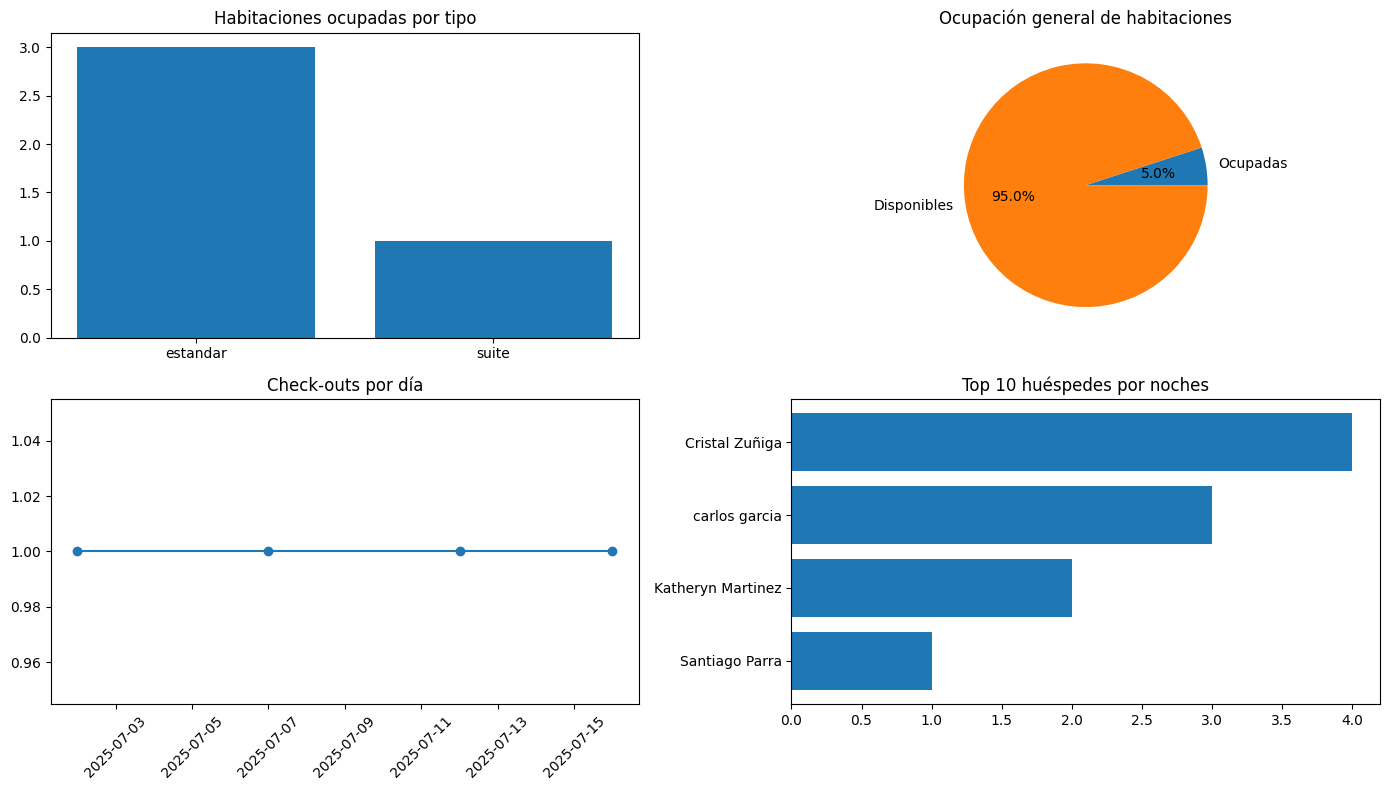

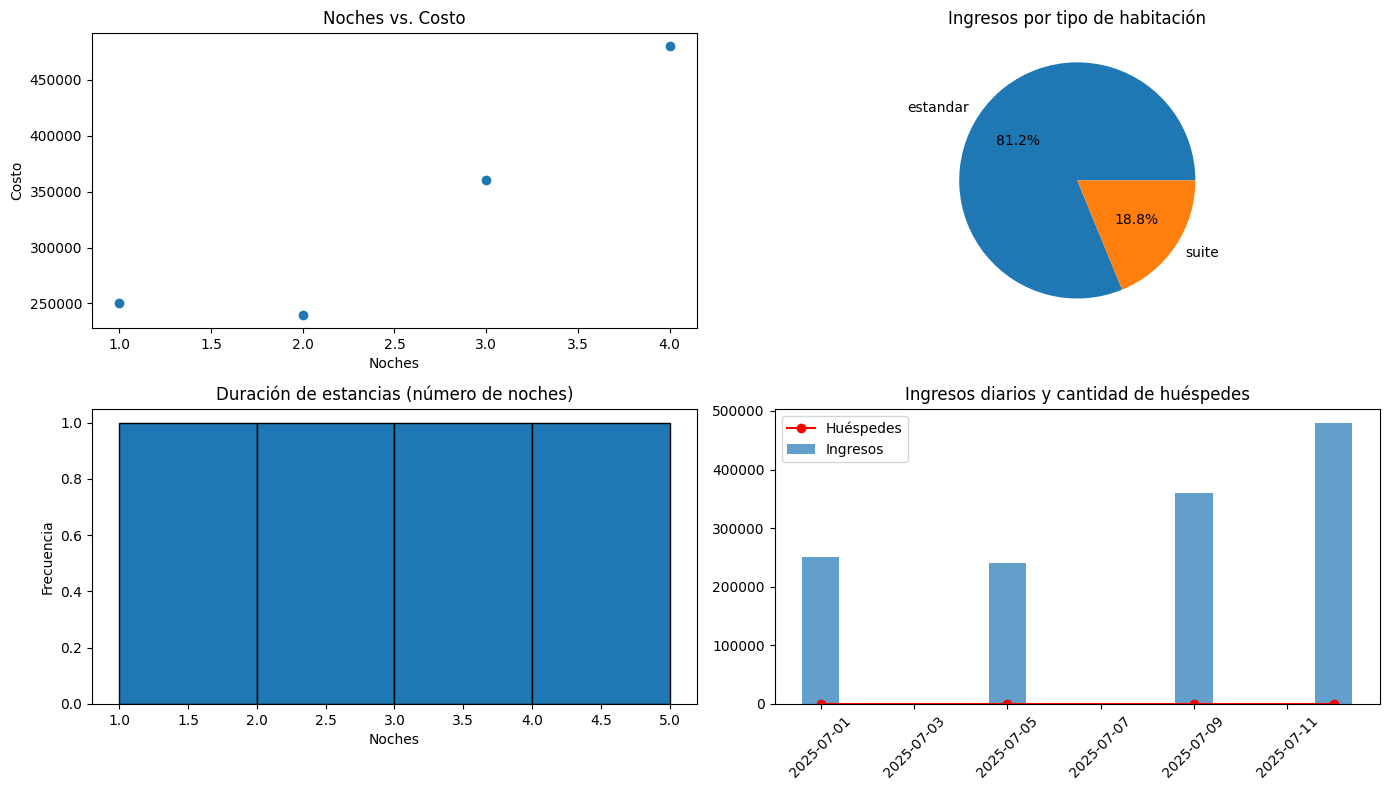


               _||_
                ||
             __|__|__
            |  HOTEL |
            |_______|
            | |   | |
            | |___| |
            |_______|

     Bienvenido al Hotel Cielo Azul
1. Registrar Huésped
2. Realizar Reserva
3. Registrar Ingreso (Check-In)
4. Registrar Salida (Check-Out)
5. Administración (Acceso restringido)
6. Salir
        
Seleccione una opción: 6
 Gracias por usar el sistema del Hotel Cielo Azul.


In [9]:
#Menu, hay que correr antes la celda de arriba y para ejecutar el programa corremos esta celda

def menu_principal():
    while True:
        print(r"""
               _||_
                ||
             __|__|__
            |  HOTEL |
            |_______|
            | |   | |
            | |___| |
            |_______|

=========================================
     Bienvenido al Hotel Cielo Azul
=========================================
1. Registrar Huésped
2. Realizar Reserva
3. Registrar Ingreso (Check-In)
4. Registrar Salida (Check-Out)
5. Administración (Acceso restringido)
6. Salir
=========================================
        """)
        opcion = input("Seleccione una opción: ").strip()

        if opcion == "1":
            registrar_huesped()
        elif opcion == "2":
            reservar_habitacion()
        elif opcion == "3":
            check_in()
        elif opcion == "4":
            registrar_salida()
        elif opcion == "5":
            usuario = input("Usuario: ")
            contraseña = input("Contraseña: ")
            if usuario in admin_usuarios and admin_usuarios[usuario] == contraseña:
                print("✅ Acceso concedido.")
                registrar_evento("Acceso al módulo de administración")
                mostrar_reportes()

                ver_graficos = input("¿Deseas ver los gráficos administrativos? (s/n): ").lower()
                if ver_graficos == "s":
                    mostrar_graficos()
            else:
                print(" Acceso denegado.")
        elif opcion == "6":
            print(" Gracias por usar el sistema del Hotel Cielo Azul.")
            registrar_evento("Salir del sistema")
            break
        else:
            print(" Opción inválida. Intente nuevamente.")





#Para correr todo

menu_principal()